In [1]:
import pandas as pd
from datasets import load_dataset
import matplotlib.pyplot as plt
import seaborn as sns

# for reproducibility
import numpy as np
np.random.seed(42)

### Load the dataset

In [2]:
# load dataset
dataset = load_dataset("fancyzhx/amazon_polarity")

### Sample the dataset

In [3]:
df_train = pd.DataFrame(dataset['train']).head(6000)
df_test = pd.DataFrame(dataset['test']).head(6000)

In [4]:
print(f"Train shape: {df_train.shape}")
print(f"Test shape: {df_test.shape}")
df_train.head()

Train shape: (6000, 3)
Test shape: (6000, 3)


,label,title,content
0,1,Stuning even for the non-gamer,This sound track was beautiful! It paints the ...
1,1,The best soundtrack ever to anything.,I'm reading a lot of reviews saying that this ...
2,1,Amazing!,This soundtrack is my favorite music of all ti...
3,1,Excellent Soundtrack,I truly like this soundtrack and I enjoy video...
4,1,"Remember, Pull Your Jaw Off The Floor After He...","If you've played the game, you know how divine..."


### basic exploration

In [5]:
lablel_counts = df_train['label'].value_counts()
print(f"Label Distribution: \n{lablel_counts}")

Label Distribution: 
label
0    3178
1    2822
Name: count, dtype: int64


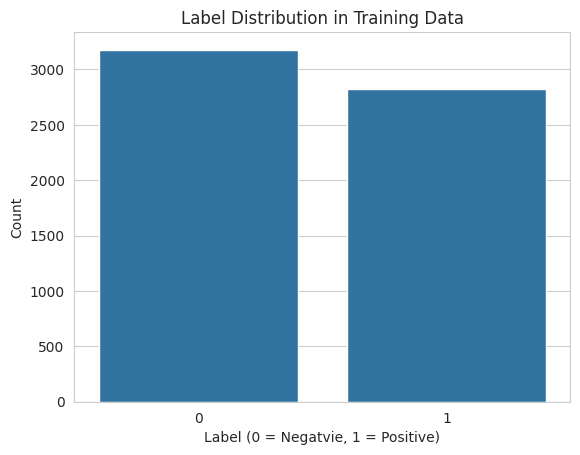

In [6]:
sns.barplot(x=lablel_counts.index, y=lablel_counts.values)
plt.title("Label Distribution in Training Data")
plt.xlabel("Label (0 = Negatvie, 1 = Positive)")
plt.ylabel("Count")
plt.show()

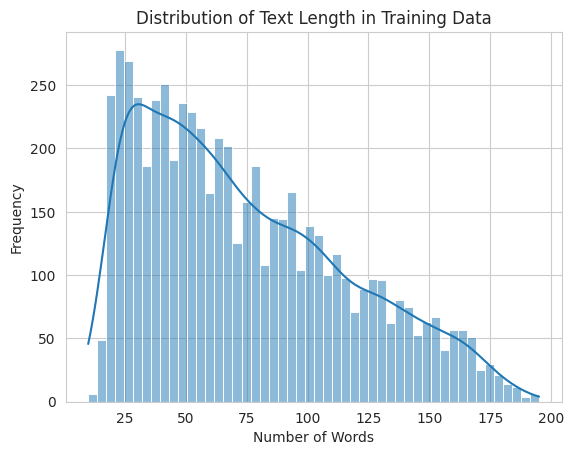

In [7]:
df_train['text_len'] = df_train['content'].apply(lambda x: len(x.split()))
sns.histplot(df_train['text_len'], bins=50, kde=True)
plt.title("Distribution of Text Length in Training Data")
plt.xlabel("Number of Words")
plt.ylabel("Frequency")
plt.show()

In [8]:
from tqdm.notebook import tqdm

# Function to create hierarchically nested training subsets
def create_nested_splits(data, steps=5):
    splits = []
    for i in tqdm(range(1, steps + 1)):
        fraction = i / steps
        split_data = data.sample(frac=fraction, random_state=42)
        splits.append(split_data)
        print(f"Split {i}: {len(split_data)} samples")
    return splits

nested_splits = create_nested_splits(df_train, steps=5)

  0%|          | 0/5 [00:00<?, ?it/s]

Split 1: 1200 samples
Split 2: 2400 samples
Split 3: 3600 samples
Split 4: 4800 samples
Split 5: 6000 samples


### Model setup and baseline training

In [9]:
from transformers import AutoTokenizer, AutoModelForSequenceClassification
from transformers import TrainingArguments, Trainer
from sklearn.metrics import accuracy_score, precision_recall_fscore_support
import torch

model_name = "distilbert-base-uncased"
tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModelForSequenceClassification.from_pretrained(model_name, num_labels=2)

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


### Tokenization of the dataset

In [10]:
def tokenize_function(examples):
    return tokenizer(examples['content'], padding="max_length", truncation=True)

train_dataset_subset = dataset['train'].select(range(6000))
test_dataset_subset = dataset['test'].select(range(6000))

# applying the tokenization function to the training and test sets
train_tokenized = train_dataset_subset.map(tokenize_function, batched=True)
test_tokenized = test_dataset_subset.map(tokenize_function, batched=True)

# preparing the pytorch datasets
train_dataset = train_tokenized.with_format('torch')
test_dataset = test_tokenized.with_format('torch')

Map:   0%|          | 0/6000 [00:00<?, ? examples/s]

### metrics definition

In [11]:
def compute_metrics(pred):
    labels = pred.label_ids
    preds = pred.predictions.argmax(-1)
    precision, recall, f1, _ = precision_recall_fscore_support(labels, preds, average='binary')
    acc = accuracy_score(labels, preds)
    return {"accuracy": acc, "f1": f1, "precision": precision, "recall": recall}

### Training arguments

In [12]:
import os
os.environ["TOKENIZERS_PARALLELISM"] = "false"

training_args = TrainingArguments(
    output_dir="results",
    eval_strategy="epoch",  # Updated from evaluation_strategy
    learning_rate=2e-5,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=16,
    num_train_epochs=3,
    weight_decay=0.01,
    logging_dir="logs",
    save_strategy="epoch",
    save_total_limit=2,
    load_best_model_at_end=True,
    metric_for_best_model="accuracy"
)

In [13]:
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=test_dataset,
    tokenizer=tokenizer,
    compute_metrics=compute_metrics
)

# Train the model
trainer.train()

# Evaluate the model
evaluation_results = trainer.evaluate()
print("Evaluation Results:", evaluation_results)

/tmp/ipykernel_20307/1402357157.py:1: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


Epoch,Training Loss,Validation Loss,Accuracy,F1,Precision,Recall
1,No log,0.263222,0.896667,0.898858,0.908042,0.889858
2,0.288500,0.357314,0.904000,0.905294,0.921969,0.889212
3,0.133500,0.375498,0.904000,0.906158,0.914201,0.898256


Evaluation Results: {'eval_loss': 0.35731419920921326, 'eval_accuracy': 0.904, 'eval_f1': 0.905294311081881, 'eval_precision': 0.9219691895512391, 'eval_recall': 0.8892118863049095, 'eval_runtime': 21.4775, 'eval_samples_per_second': 279.362, 'eval_steps_per_second': 17.46, 'epoch': 3.0}


In [14]:
# Save model and tokenizer
model.save_pretrained("results/sentiment_model")
tokenizer.save_pretrained("results/sentiment_model")

('results/sentiment_model/tokenizer_config.json',
 'results/sentiment_model/special_tokens_map.json',
 'results/sentiment_model/vocab.txt',
 'results/sentiment_model/added_tokens.json',
 'results/sentiment_model/tokenizer.json')

In [15]:
from sentence_transformers import SentenceTransformer
import numpy as np

# Load transformer model
embedding_model = SentenceTransformer("all-MiniLM-L6-v2")

# Generate embeddings for training and test data
train_embeddings = embedding_model.encode(df_train['content'].tolist(), show_progress_bar=True)
test_embeddings = embedding_model.encode(df_test['content'].tolist(), show_progress_bar=True)

# Save embeddings
np.save("train_embeddings.npy", train_embeddings)
np.save("test_embeddings.npy", test_embeddings)

modules.json:   0%|          | 0.00/349 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/116 [00:00<?, ?B/s]

README.md:   0%|          | 0.00/10.7k [00:00<?, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/612 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/90.9M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/350 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

1_Pooling/config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

Batches:   0%|          | 0/188 [00:00<?, ?it/s]

Batches:   0%|          | 0/188 [00:00<?, ?it/s]

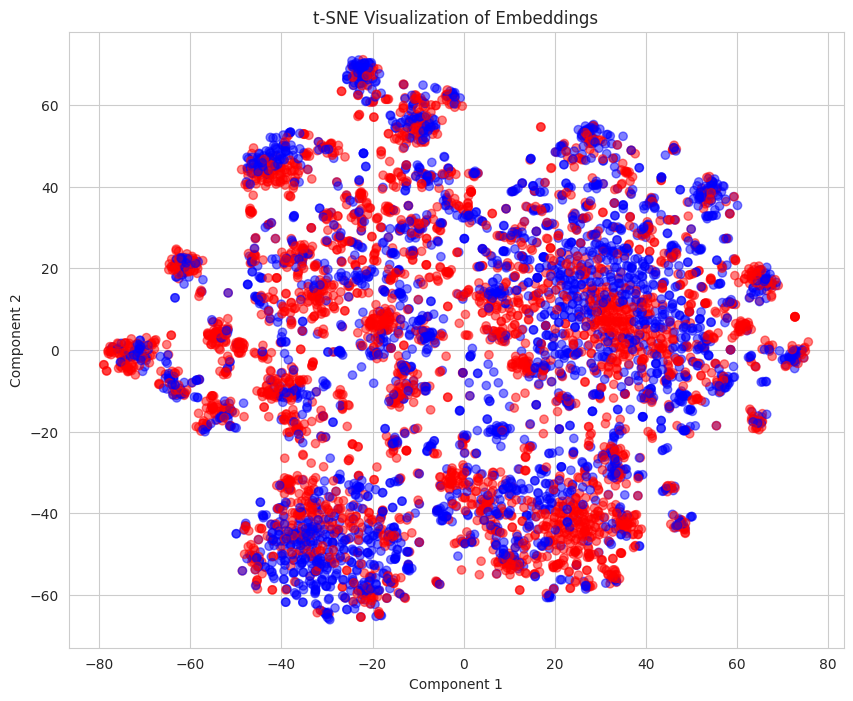

In [16]:
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt

# Perform dimensionality reduction
tsne = TSNE(n_components=2, random_state=42)
reduced_embeddings = tsne.fit_transform(train_embeddings)

# Visualize
plt.figure(figsize=(10, 8))
colors = ['red' if label == 0 else 'blue' for label in df_train['label']]
plt.scatter(reduced_embeddings[:, 0], reduced_embeddings[:, 1], c=colors, alpha=0.5)
plt.title("t-SNE Visualization of Embeddings")
plt.xlabel("Component 1")
plt.ylabel("Component 2")
plt.show()

In [17]:
from sklearn.metrics.pairwise import cosine_similarity

# Function to generate weak labels
def generate_weak_labels(unlabeled_embeddings, labeled_embeddings, labeled_labels, top_k=3):
    similarities = cosine_similarity(unlabeled_embeddings, labeled_embeddings)
    weak_labels = []

    for sim in similarities:
        # Find top-k most similar labeled examples
        top_k_indices = sim.argsort()[-top_k:][::-1]
        top_k_labels = [labeled_labels[i] for i in top_k_indices]

        # Assign the majority label
        weak_labels.append(max(set(top_k_labels), key=top_k_labels.count))

    return weak_labels

# Example: Generate weak labels for test set using train embeddings
weak_labels = generate_weak_labels(test_embeddings, train_embeddings, df_train['label'].tolist())
df_test['weak_label'] = weak_labels

In [18]:
from sklearn.metrics import classification_report

# Evaluate weak labels
print("Weak Label Evaluation:")
print(classification_report(df_test['label'], df_test['weak_label'], target_names=["Negative", "Positive"]))

Weak Label Evaluation:
              precision    recall  f1-score   support

    Negative       0.67      0.71      0.69      2904
    Positive       0.71      0.67      0.69      3096

    accuracy                           0.69      6000
   macro avg       0.69      0.69      0.69      6000
weighted avg       0.69      0.69      0.69      6000



### Model training with weak labels

In [19]:
# Combine weak labels with original training data
df_combined_train = pd.concat([
    df_train[['content', 'label']],  # Original labeled data
    df_test[['content', 'weak_label']].rename(columns={'weak_label': 'label'})  # Weakly labeled data
]).reset_index(drop=True)

print("Combined Dataset Shape:", df_combined_train.shape)

Combined Dataset Shape: (12000, 2)


In [20]:
# Tokenize the combined dataset
combined_dataset = df_combined_train.to_dict(orient='records')

def tokenize_combined_function(examples):
    return tokenizer(examples['content'], padding="max_length", truncation=True)

tokenized_combined_dataset = tokenizer(
    df_combined_train['content'].tolist(),
    padding="max_length",
    truncation=True,
    max_length=512,
    return_tensors="pt"
)

# Prepare inputs for PyTorch Dataset
labels_combined = torch.tensor(df_combined_train['label'].tolist())

In [21]:
from torch.utils.data import Dataset, DataLoader

# Create a custom dataset class
class SentimentDataset(Dataset):
    def __init__(self, encodings, labels):
        self.encodings = encodings
        self.labels = labels

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        item = {key: val[idx] for key, val in self.encodings.items()}
        item['labels'] = self.labels[idx]
        return item

# Prepare DataLoader
combined_dataset = SentimentDataset(tokenized_combined_dataset, labels_combined)
train_loader = DataLoader(combined_dataset, batch_size=16, shuffle=True)

In [23]:
training_args_combined = TrainingArguments(
    output_dir="./results_combined",
    evaluation_strategy="epoch",
    learning_rate=2e-5,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=16,
    num_train_epochs=3,
    weight_decay=0.01,
    logging_dir="./logs_combined",
    save_strategy="epoch",
    save_total_limit=2,
    load_best_model_at_end=True,
    metric_for_best_model="accuracy"
)

# Tokenize the test dataset
test_tokenized = tokenizer(
    df_test['content'].tolist(),
    padding="max_length",
    truncation=True,
    max_length=512,
    return_tensors="pt"
)

# Prepare labels for the test dataset
labels_test = torch.tensor(df_test['label'].tolist())

# Create a test dataset object
test_dataset = SentimentDataset(test_tokenized, labels_test)

trainer_combined = Trainer(
    model=model,
    args=training_args_combined,
    train_dataset=combined_dataset,
    eval_dataset=test_dataset,
    tokenizer=tokenizer,
    compute_metrics=compute_metrics
)

# Train the model with combined labels
trainer_combined.train()

# Evaluate the model
evaluation_combined_results = trainer_combined.evaluate()
print("Combined Training Evaluation Results:", evaluation_combined_results)

/home/arian/miniconda3/envs/npr_mc2_hs24/lib/python3.9/site-packages/transformers/training_args.py:1575: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(
/tmp/ipykernel_20307/1451112842.py:31: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer_combined = Trainer(


Epoch,Training Loss,Validation Loss,Accuracy,F1,Precision,Recall
1,0.447300,0.353824,0.858167,0.867135,0.839226,0.896964
2,0.344000,0.447566,0.822667,0.825058,0.840255,0.810401
3,0.267900,0.589030,0.802667,0.806662,0.815720,0.797804


Combined Training Evaluation Results: {'eval_loss': 0.35382357239723206, 'eval_accuracy': 0.8581666666666666, 'eval_f1': 0.8671350507416081, 'eval_precision': 0.8392263523723179, 'eval_recall': 0.8969638242894057, 'eval_runtime': 21.4147, 'eval_samples_per_second': 280.181, 'eval_steps_per_second': 17.511, 'epoch': 3.0}


In [24]:
# Display results side by side
print("Baseline Evaluation Results:", evaluation_results)
print("Combined Training Evaluation Results:", evaluation_combined_results)

Baseline Evaluation Results: {'eval_loss': 0.35731419920921326, 'eval_accuracy': 0.904, 'eval_f1': 0.905294311081881, 'eval_precision': 0.9219691895512391, 'eval_recall': 0.8892118863049095, 'eval_runtime': 21.4775, 'eval_samples_per_second': 279.362, 'eval_steps_per_second': 17.46, 'epoch': 3.0}
Combined Training Evaluation Results: {'eval_loss': 0.35382357239723206, 'eval_accuracy': 0.8581666666666666, 'eval_f1': 0.8671350507416081, 'eval_precision': 0.8392263523723179, 'eval_recall': 0.8969638242894057, 'eval_runtime': 21.4147, 'eval_samples_per_second': 280.181, 'eval_steps_per_second': 17.511, 'epoch': 3.0}


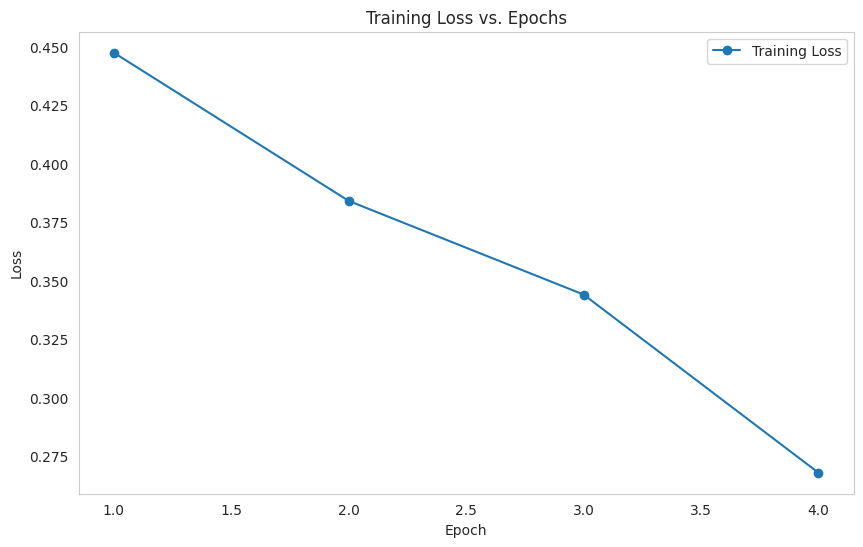

In [25]:
import matplotlib.pyplot as plt

# Extract training metrics from the Trainer's logs
train_loss = trainer_combined.state.log_history
train_loss = [entry['loss'] for entry in train_loss if 'loss' in entry]
epochs = range(1, len(train_loss) + 1)

# Plot training loss
plt.figure(figsize=(10, 6))
plt.plot(epochs, train_loss, marker='o', label="Training Loss")
plt.title("Training Loss vs. Epochs")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.grid()
plt.show()

      Model  Accuracy  F1-Score  Precision    Recall
0  Baseline  0.904000  0.905294   0.921969  0.889212
1  Combined  0.858167  0.867135   0.839226  0.896964


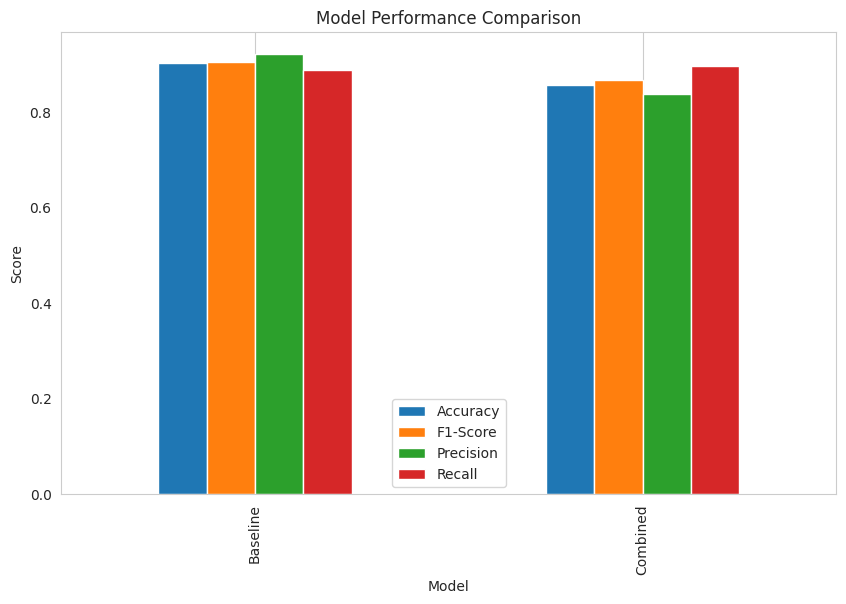

In [26]:
import pandas as pd

# Create a summary DataFrame
comparison = pd.DataFrame({
    "Model": ["Baseline", "Combined"],
    "Accuracy": [evaluation_results["eval_accuracy"], evaluation_combined_results["eval_accuracy"]],
    "F1-Score": [evaluation_results["eval_f1"], evaluation_combined_results["eval_f1"]],
    "Precision": [evaluation_results["eval_precision"], evaluation_combined_results["eval_precision"]],
    "Recall": [evaluation_results["eval_recall"], evaluation_combined_results["eval_recall"]]
})

# Display the comparison
print(comparison)

# Visualize the comparison
comparison.set_index("Model").plot(kind="bar", figsize=(10, 6))
plt.title("Model Performance Comparison")
plt.ylabel("Score")
plt.xlabel("Model")
plt.grid(axis='y')
plt.show()